In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import torch.optim as optim

In [2]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
        nn.Conv2d(1, 32, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, 3, 1),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(2*2*128, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [3]:
class VisualBackpropWrapper():
    """
        Wraps the model and gives ability to extract importance masks
        for feature layers in convolutional networks.
        Implements idea from article: https://arxiv.org/pdf/1611.05418.pdf
        Wrapped model must have nn.Sequential fileld named "features" with all features layers
    """
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.initialize_modules()

    """
        Initializes self.modules and its params from net structure
    """
    def initialize_modules(self):
        self.modules = []
        for _, module in self.model.features._modules.items():
            transformation_params = None
            if 'Conv2d' in str(module):
                transformation_params = (module.kernel_size, module.stride, module.padding)
            if 'Pool' in str(module):
                transformation_params = ((module.kernel_size, module.kernel_size), \
                                        (module.stride, module.stride), \
                                        (module.padding, module.padding))
            self.modules.append((module, transformation_params))

    """
        Return relevancy masks for batch of images computed by VisualBackprop
    """
    def get_masks_for_batch(self, x_batch):
        all_outputs = []
        x_batch = x_batch.to(self.device)
        for module, transformation_params in self.modules:
            x_batch = module(x_batch)
            averaged_maps = torch.mean(x_batch, 1, True)
            flatten_maps = averaged_maps.view(averaged_maps.size(0), -1)
            maps_max = torch.max(flatten_maps, 1, True)[0].unsqueeze(2).unsqueeze(3)
            maps_min = torch.min(flatten_maps, 1, True)[0].unsqueeze(2).unsqueeze(3)
            averaged_maps = (averaged_maps - maps_min) / (maps_max - maps_min + 1e-6)
            if transformation_params:
                all_outputs.append((averaged_maps, transformation_params))

        last_result = None
        for maps, (kernel_size, stride, padding) in reversed(all_outputs):
            if last_result is None:
                last_result = maps
            else:
                last_result = last_result.mul(maps)
            last_result = F.conv_transpose2d(last_result, torch.ones(1, 1, kernel_size[0], kernel_size[1], device=self.device),\
                                            stride=stride, output_padding=padding)
        return F.relu(last_result)

In [4]:
def visualize_images_with_masks(images, masks, text, figsize=(16, 8), columns=5):
    fig=plt.figure(figsize=figsize)
    fig.suptitle(text, fontsize=14, fontweight='bold')
    columns = 3
    rows = (images.shape[0] + columns - 1) // columns

    red_mask = np.zeros((images.shape[0], images.shape[2], images.shape[3], 4))
    masks_np = masks.detach().cpu().numpy()
    red_mask[:,:,:,0] = np.squeeze(masks_np, 1)
    red_mask[:,:,:,3] = red_mask[:,:,:,0]

    for i in range(images.shape[0]):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.imshow(red_mask[i] / np.max(red_mask[i]))


def train_with_logging(model, device, train_loader, optimizer, total_num_iterations, \
                       log_freq, display_samples, save_dir='./results/'):
    model.train()
    num_iterations = 0
    while(num_iterations < total_num_iterations):
        for _, (data, target) in enumerate(train_loader):
            if num_iterations >= total_num_iterations:
                break
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(F.log_softmax(output), target)
            loss.backward()
            optimizer.step()
            if num_iterations % log_freq == 0:
                with torch.no_grad():
                    visual_backprop = VisualBackpropWrapper(model, device)
                    display_masks = visual_backprop.get_masks_for_batch(display_samples)
                    visualize_images_with_masks(display_samples, display_masks, "Iteration %d" % num_iterations)
                    plt.savefig(os.path.join(save_dir, "%05d.jpg" % (num_iterations)))
                    plt.close()
            num_iterations += 1

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    ])), batch_size=9, shuffle=True)

test_batch = None
for x in test_loader:
    test_batch = x[0]
    break

In [7]:
# Use cpu if no cuda available
device = torch.device("cuda")
#device = torch.device("cpu")

model = LeNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_with_logging(model, device, train_loader, optimizer, 200, 5, test_batch)

<ipython-input-4-f78a6c423af3>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = F.nll_loss(F.log_softmax(output), target)
<ipython-input-4-f78a6c423af3>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = F.nll_loss(F.log_softmax(output), target)
<ipython-input-4-f78a6c423af3>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = F.nll_loss(F.log_softmax(output), target)
<ipython-input-4-f78a6c423af3>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = F.nll_loss(F.log_softmax(output), target)
<ipython-input-4-f78a6c423af3>:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argume

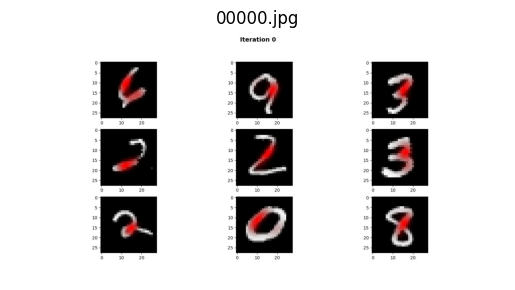

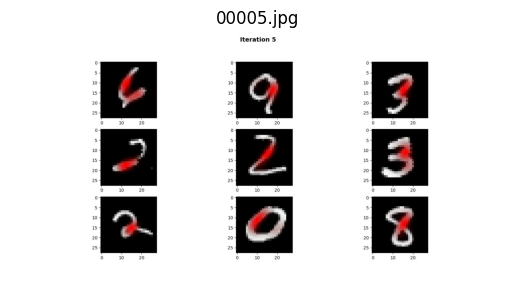

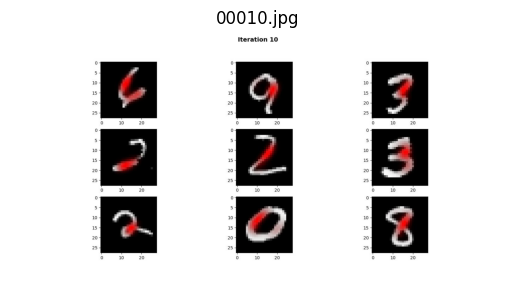

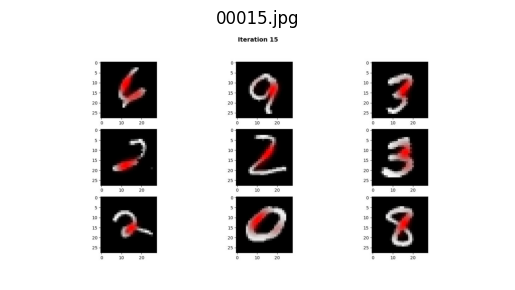

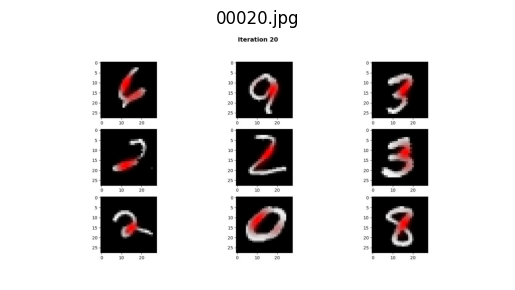

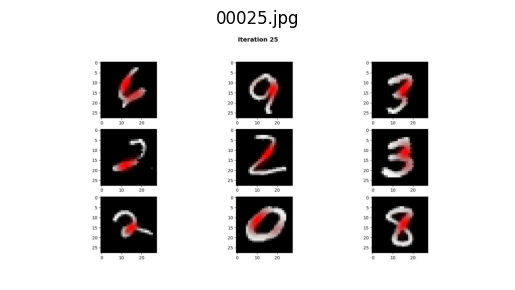

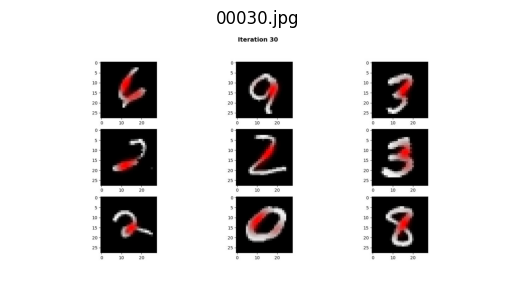

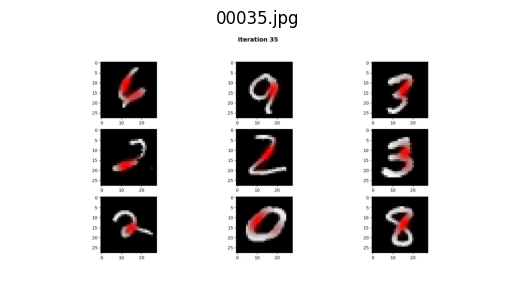

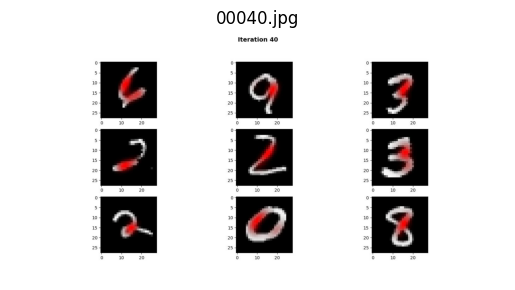

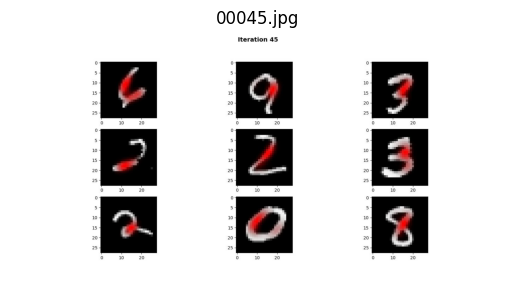

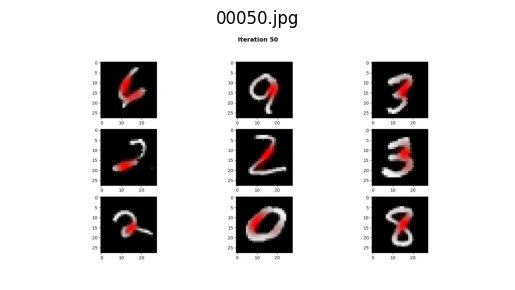

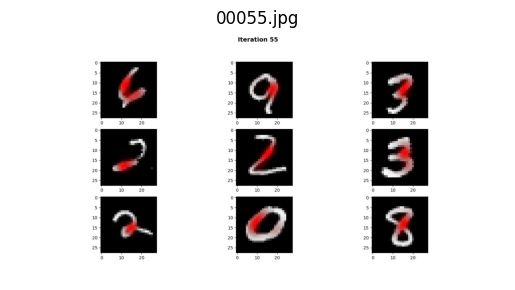

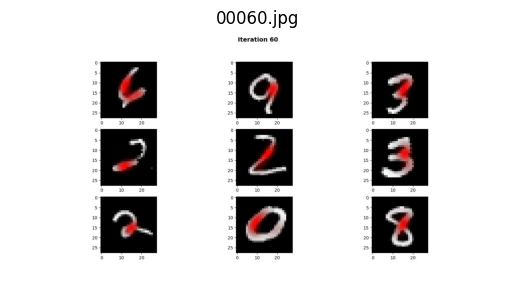

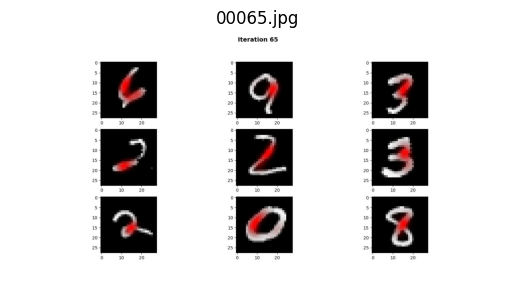

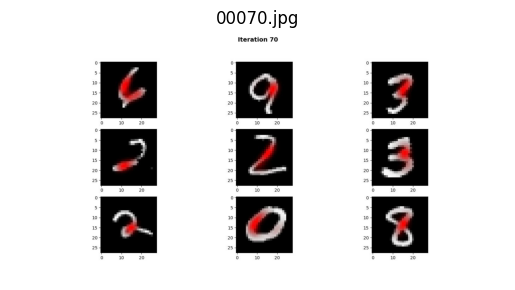

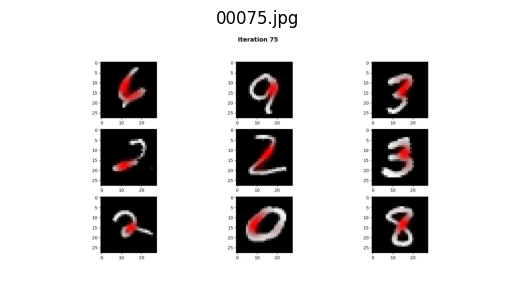

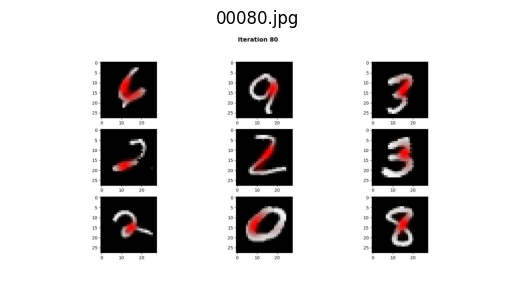

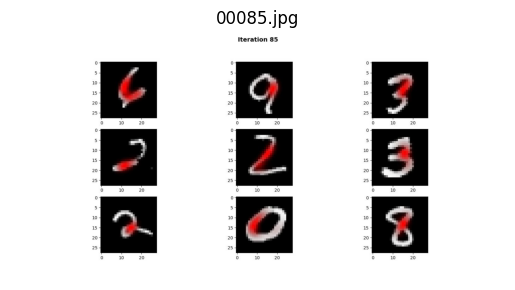

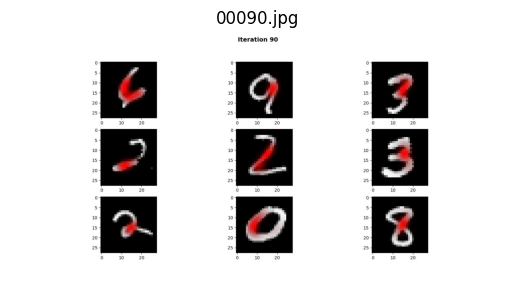

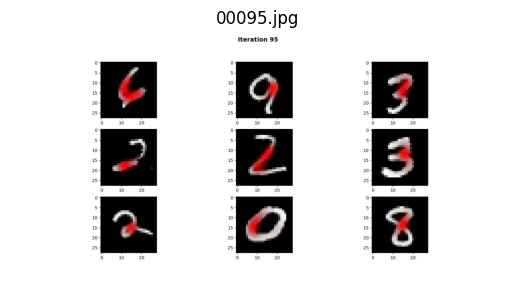

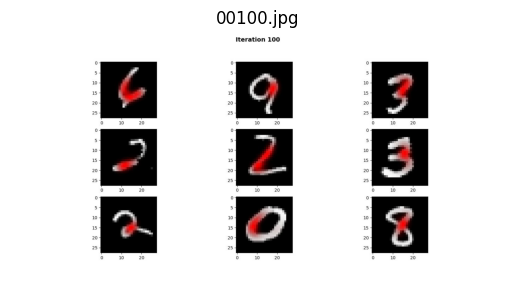

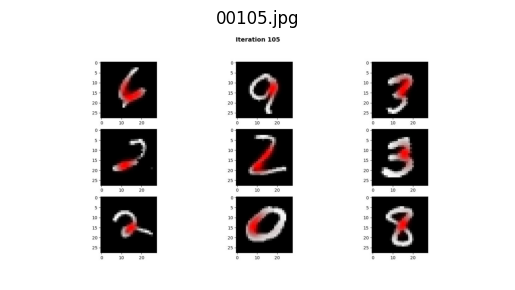

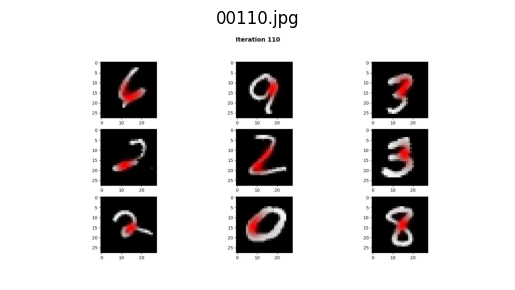

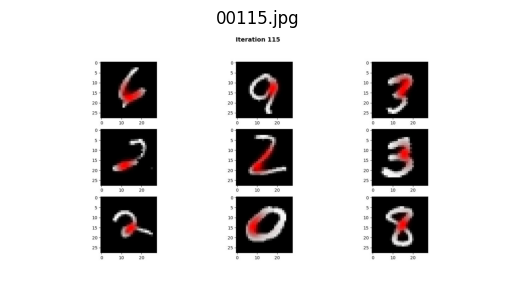

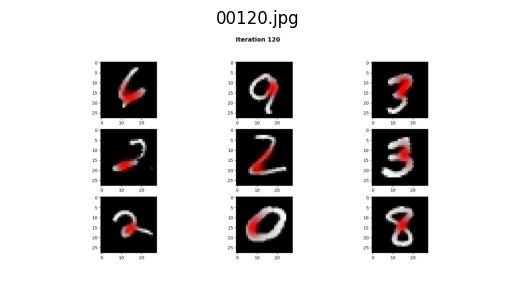

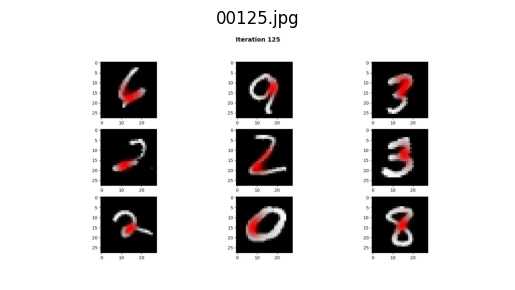

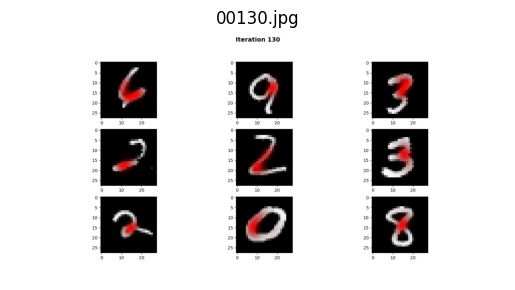

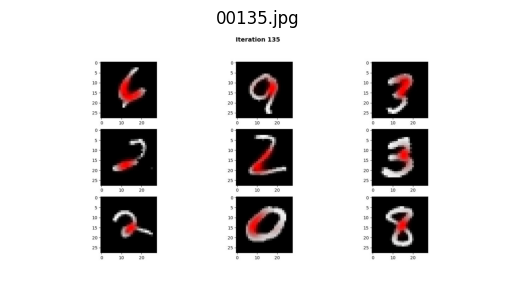

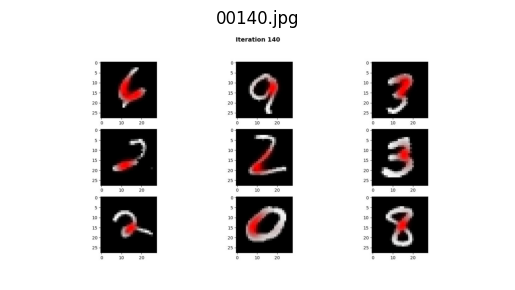

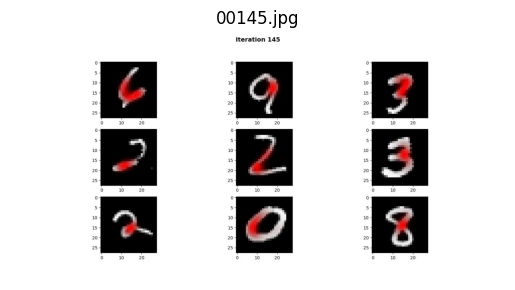

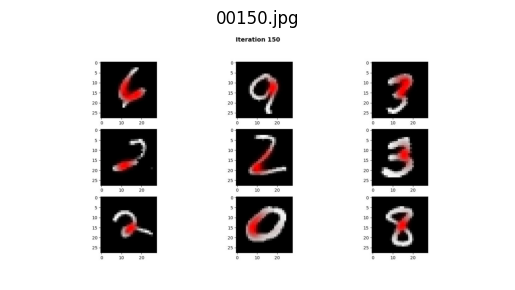

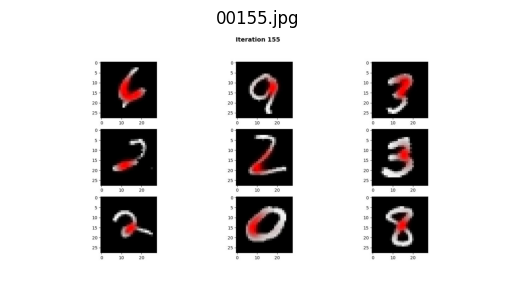

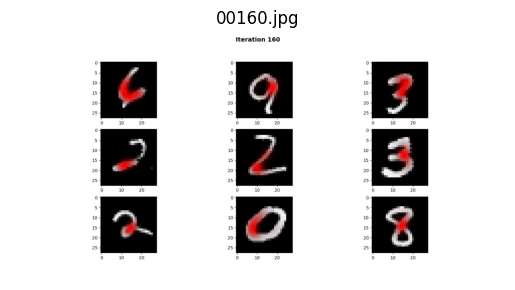

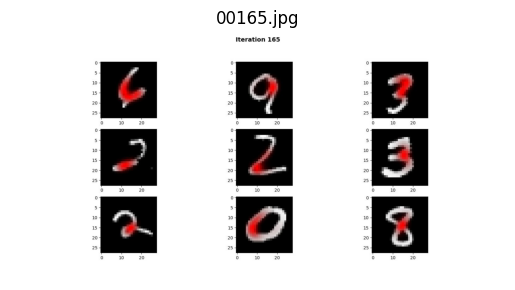

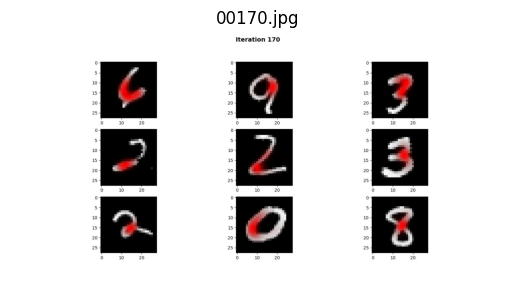

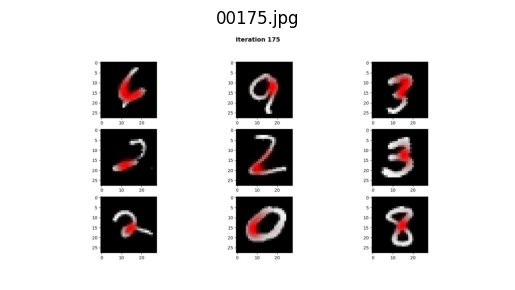

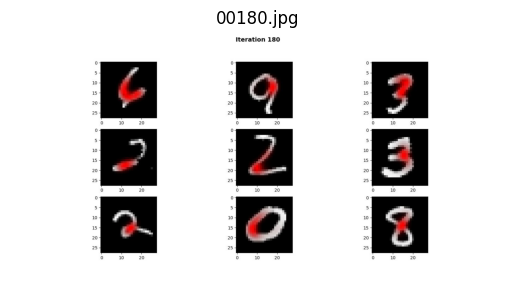

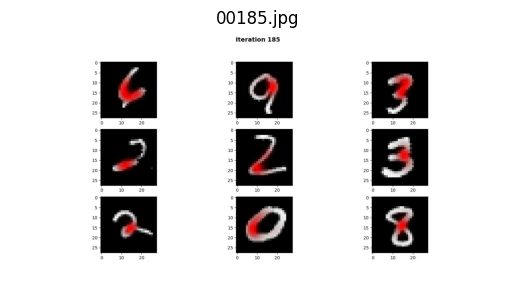

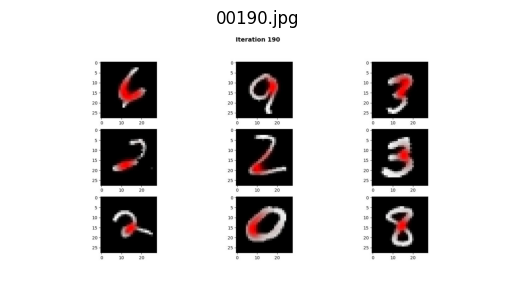

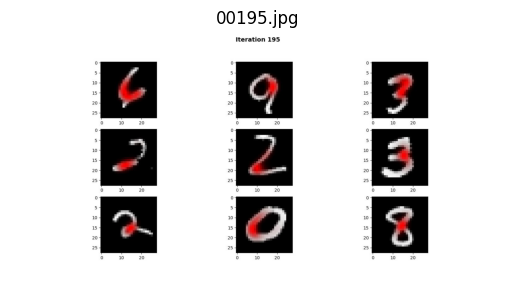

In [8]:
image_files = [f for f in os.listdir('./results/') if f.endswith('.jpg')]
image_files.sort()

for image_file in image_files:
    # Construct the full path to the image
    image_path = os.path.join('./results/', image_file)

    # Load and display the image
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')  # Turn off axis
    plt.show()